/home/george/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


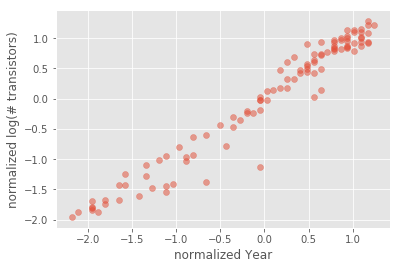

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import re
from sklearn.utils import shuffle
from sklearn import preprocessing
import pymc

%matplotlib inline  
plt.style.use('ggplot')

# Load and preprocess data
X = []
Y = []

non_decimal = re.compile(r'[^\d]+')

for line in open('moore.csv'):
    r = line.split('\t')
    x = int(non_decimal.sub('', r[2].split('[')[0]))
    y = int(non_decimal.sub('', r[1].split('[')[0]))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X, Y = shuffle(X, Y, random_state=0)
X.shape = (X.shape[0], 1)
X = preprocessing.scale(X)
Y = preprocessing.scale(np.log(Y))

# split data into training and test set
N, M = X.shape
idx = int(0.8*N)
X_train = X[:idx, :]
Y_train = Y[:idx]
N_train = idx
X_test = X[idx:, :]
Y_test = Y[idx:]
N_test = N - N_train

plt.scatter(X, Y, alpha=0.5)
plt.xlabel('normalized Year')
plt.ylabel('normalized log(# transistors)')

In [2]:
# Pystan model for Ridge Regression

ridge_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ normal(1, 10);
    sigma ~ uniform(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    Y_pred <- X_test*beta + intercept; //the y values predicted by the model
    
}
"""

# dictionary containing data
data = {
    'X_train': X_test,
    'Y_train': Y_test,
    'N_train': N_test,
    'X_test': X_test,
    'N_test': N_test,
    'M': M
}

# fit model
fit = pystan.stan(model_code=ridge_code, data=data, iter=2000, chains=1)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8211d49f00f14413e28c527d30d3f3ef NOW.


Inference for Stan model: anon_model_8211d49f00f14413e28c527d30d3f3ef.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept   -0.06  2.5e-3   0.08  -0.21  -0.11  -0.07  -0.01   0.09    882    1.0
beta[0]      0.97  2.8e-3   0.09    0.8   0.91   0.97   1.03   1.15   1000    1.0
sigma        0.33  1.9e-3   0.06   0.24   0.29   0.32   0.36   0.46   1000    1.0
Y_pred[0]   -0.85  4.2e-3   0.12  -1.11  -0.93  -0.86  -0.78  -0.61    807    1.0
Y_pred[1]   -0.11  2.6e-3   0.08  -0.26  -0.16  -0.11  -0.06   0.04    867    1.0
Y_pred[2]    0.85  2.9e-3   0.09   0.67   0.79   0.85   0.92   1.02   1000    1.0
Y_pred[3]    0.11  2.3e-3   0.07  -0.03   0.06   0.11   0.16   0.25    955    1.0
Y_pred[4]   -0.11  2.6e-3   0.08  -0.26  -0.16  -0.11  -0.06   0.04    867    1.0
Y_pred[5]    0.55  2.5e-3   0.08   0.41    0.5   0.55   0.61    0.7   100

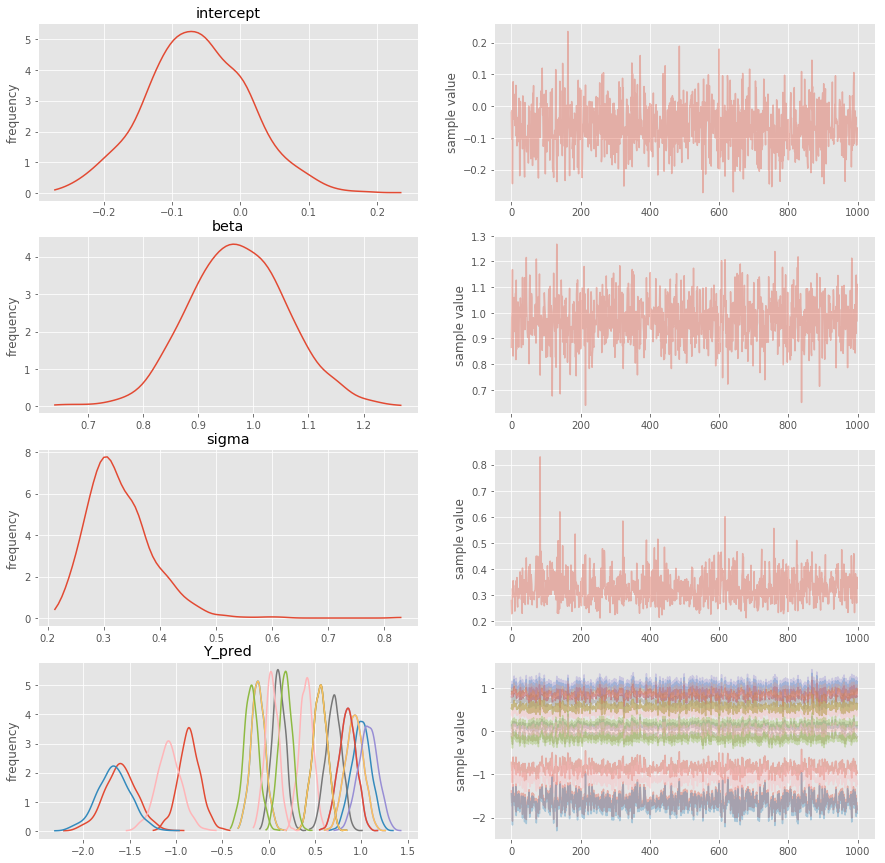

In [3]:
fig = fit.plot()
fig.set_size_inches(15, 15)

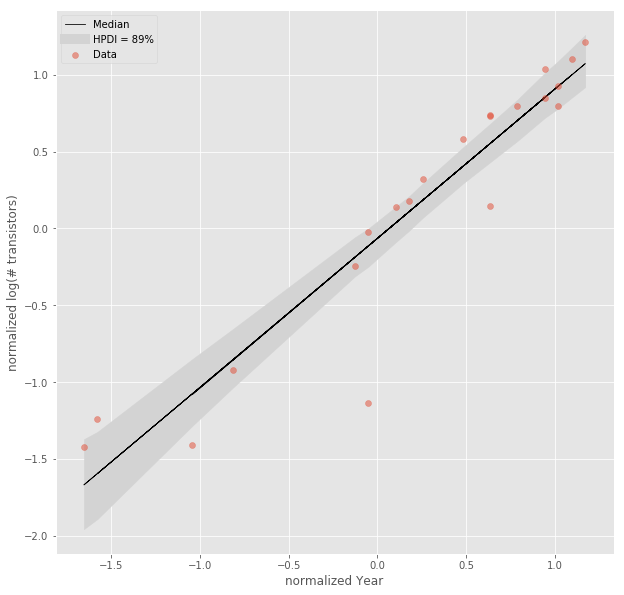

In [5]:
Y_pred = fit.extract('Y_pred')['Y_pred']
Y_hpdi = pymc.utils.hpd(Y_pred, 0.11)
Y_lower = Y_hpdi[0, :]
Y_upper = Y_hpdi[1, :]

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
ax.plot(X_test, np.median(Y_pred, axis=0), linewidth=0.8, color='k', label='Median', zorder=2)
ax.scatter(X_test, Y_test, alpha=0.5, label='Data', zorder=3)
sorted_x = X_test[:, 0].argsort()
Y_upper = Y_upper[sorted_x]
Y_lower = Y_lower[sorted_x]
X_test_sorted = X_test[sorted_x, :]
ax.fill_between(X_test_sorted[:, 0], Y_upper, Y_lower, color='lightgrey')
ax.plot([], [], color='lightgrey', label='HPDI = 89%', linewidth=10)
ax.legend(loc='upper left')
plt.xlabel('normalized Year')
plt.ylabel('normalized log(# transistors)')